In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape
import keras.backend as K
import math
from keras.applications import DenseNet169,DenseNet201,DenseNet121,NASNetMobile,MobileNet,MobileNetV2

Using TensorFlow backend.


In [2]:
rotated = True
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13885289181360152950, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16029502669
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14699244240985801853
 physical_device_desc: "device: 0, name: Quadro P5000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [3]:
with open('data-localize-rotated0.pckl','rb') as file:
    train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes,test_bbox_sizes,test_bboxes_rot = pickle.load(file)

In [4]:
def convert_bboxes(bboxes):
    features = []
    for b in bboxes:
        height = math.sqrt((b[0]-b[2])**2 + (b[1]-b[3])**2)
        width = math.sqrt((b[2]-b[4])**2 + (b[3]-b[5])**2)
        
        cx = (b[0] + b[4])/2.0
        cy = (b[1] + b[5])/2.0
        
        
        angle = math.atan2((b[2]-b[0]),(b[3]-b[1]))
        features.append([height,width,cx,cy,angle])
    return np.array(features)

In [5]:
#num_labels = len(np.unique(labels))

def iou_metric(y_true, y_pred):
    # iou as metric for bounding box regression
    # input must be as [x1, y1, x2, y2]
    
    # AOG = Area of Groundtruth box
    AoG = K.abs(K.transpose(y_true)[2] - K.transpose(y_true)[0] + 1) * K.abs(K.transpose(y_true)[3] - K.transpose(y_true)[1] + 1)
    
    # AOP = Area of Predicted box
    AoP = K.abs(K.transpose(y_pred)[2] - K.transpose(y_pred)[0] + 1) * K.abs(K.transpose(y_pred)[3] - K.transpose(y_pred)[1] + 1)

    # overlaps are the co-ordinates of intersection box
    overlap_0 = K.maximum(K.transpose(y_true)[0], K.transpose(y_pred)[0])
    overlap_1 = K.maximum(K.transpose(y_true)[1], K.transpose(y_pred)[1])
    overlap_2 = K.minimum(K.transpose(y_true)[2], K.transpose(y_pred)[2])
    overlap_3 = K.minimum(K.transpose(y_true)[3], K.transpose(y_pred)[3])

    # intersection area
    intersection = (overlap_2 - overlap_0 + 1) * (overlap_3 - overlap_1 + 1)

    # area of union of both boxes
    union = AoG + AoP - intersection
    
    # iou calculation
    iou = intersection / union

    # bounding values of iou to (0,1)
    iou = K.clip(iou, 0.0 + K.epsilon(), 1.0 - K.epsilon())

    return iou    

In [6]:
cnn_base = MobileNetV2(input_shape=(224,224,3),include_top=True, weights='imagenet')

    #for layer in cnn_base.layers:
        #if layer.name=='block5_conv3':
        #    break
        #layer.trainable = False

x = cnn_base.get_layer('out_relu').output
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
#x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)
#x = BatchNormalization()(x)
if rotated==True:
    x = Conv2D(5, kernel_size=(1, 1), padding="same")(x)
    x = Reshape((5,),name='localization_output')(x)
else: 
    x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
    x = Reshape((4,),name='localization_output')(x)

y = cnn_base.layers[-2].output
y = BatchNormalization()(y)
y = Dense(1024,activation='relu')(y)
y = BatchNormalization()(y)
y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

losses = {
    "localization_output": "mean_squared_error",
    "classification_output": "categorical_crossentropy",
}
lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

model = Model(inputs=cnn_base.input, outputs=[x,y])
#if rotated==True:
model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy']})

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
__________________________________________________________________________________________________
expanded_c

In [8]:
def get_model(rotated):
    cnn_base = MobileNetV2(input_shape=(224,224,3),include_top=True, weights='imagenet')

    #for layer in cnn_base.layers:
        #if layer.name=='block5_conv3':
        #    break
        #layer.trainable = False

    x = cnn_base.get_layer('out_relu').output
    x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
    x = MaxPooling2D(pool_size=(4, 4))(x)
    x = BatchNormalization()(x)
    #x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
    #x = MaxPooling2D(pool_size=(2, 2))(x)
    #x = BatchNormalization()(x)
    if rotated==True:
        x = Conv2D(5, kernel_size=(1, 1), padding="same")(x)
        x = Reshape((5,),name='localization_output')(x)
    else: 
        x = Conv2D(4, kernel_size=(1, 1), padding="same")(x)
        x = Reshape((4,),name='localization_output')(x)

    y = cnn_base.layers[-2].output
    y = BatchNormalization()(y)
    y = Dense(2048,activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dense(test_labels.shape[1],activation='softmax',name='classification_output')(y)

    losses = {
        "localization_output": "mean_squared_error",
        "classification_output": "categorical_crossentropy",
    }
    lossWeights = {"localization_output": 1.0, "classification_output": 1.0}

    model = Model(inputs=cnn_base.input, outputs=[x,y])
    #if rotated==True:
    model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy']})
        #model.save_weights('vgg19-localization-weights-rotated1.h5')
    #else:
        #model.compile(loss=losses, optimizer="adam", metrics={'classification_output':'accuracy', 'localization_output':['accuracy',iou_metric]})
        #model.save_weights('abc.hd5')
    return model

In [9]:
len(train_images)

7755

In [10]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

for i in range(5):
    print("Loading file")
    #model.save_weights('model.h5')
    with open('data-localize-rotated'+str(i)+'.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes,test_bbox_sizes,_ = pickle.load(file)
    mod = get_model(rotated)
#     try:
#         model.load_weights('vgg19-localization-rotated'+str(i)+'.hd5')
#     except:
#         model.load_weights('vgg19-localization-weights-rotated.h5')
    print("loaded")
    train_bboxes = convert_bboxes(train_bboxes)
    test_bboxes = convert_bboxes(test_bboxes)
    history = mod.fit(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": train_bboxes},batch_size=5,epochs=10,
                       validation_data=(np.array(test_images),{"classification_output": test_labels, "localization_output": test_bboxes}))
    history_record.append(history)
    train_score = mod.evaluate(x=np.array(train_images),y={"classification_output": np.array(train_labels), "localization_output": train_bboxes},batch_size=50)
    test_score = mod.evaluate(x=np.array(test_images),y={"classification_output": test_labels, "localization_output": test_bboxes},batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = mod.predict(x=np.array(train_images),batch_size=50)
    test_predictions = mod.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    #model.load_weights()
    #if rotated:
    #    model.save_weights('vgg19-localization-rotated'+str(i)+'.hd5')
    #else:
    #   model.save_weights('vgg19-localization'+str(i)+'.hd5')

Loading file
loaded
Train on 7755 samples, validate on 647 samples
Epoch 1/40
7755/7755 [==============================] - 189s 24ms/step - loss: 2157.7811 - localization_output_loss: 2155.7172 - classification_output_loss: 2.0639 - localization_output_acc: 0.5074 - classification_output_acc: 0.2979 - val_loss: 1149.8507 - val_localization_output_loss: 1144.8093 - val_classification_output_loss: 5.0414 - val_localization_output_acc: 0.4235 - val_classification_output_acc: 0.2442
Epoch 2/40
7755/7755 [==============================] - 173s 22ms/step - loss: 942.5013 - localization_output_loss: 940.6909 - classification_output_loss: 1.8104 - localization_output_acc: 0.5625 - classification_output_acc: 0.3242 - val_loss: 1121.1785 - val_localization_output_loss: 1115.9168 - val_classification_output_loss: 5.2617 - val_localization_output_acc: 0.5502 - val_classification_output_acc: 0.1731
Epoch 3/40
7755/7755 [==============================] - 173s 22ms/step - loss: 894.3715 - localizatio

Epoch 21/40
7755/7755 [==============================] - 170s 22ms/step - loss: 522.5846 - localization_output_loss: 521.3588 - classification_output_loss: 1.2258 - localization_output_acc: 0.7224 - classification_output_acc: 0.5119 - val_loss: 612.9394 - val_localization_output_loss: 611.6345 - val_classification_output_loss: 1.3049 - val_localization_output_acc: 0.6739 - val_classification_output_acc: 0.4776
Epoch 22/40
7755/7755 [==============================] - 170s 22ms/step - loss: 500.3597 - localization_output_loss: 499.1239 - classification_output_loss: 1.2358 - localization_output_acc: 0.7304 - classification_output_acc: 0.5115 - val_loss: 438.4100 - val_localization_output_loss: 437.1945 - val_classification_output_loss: 1.2155 - val_localization_output_acc: 0.7326 - val_classification_output_acc: 0.5410
Epoch 23/40
7755/7755 [==============================] - 170s 22ms/step - loss: 509.0607 - localization_output_loss: 507.8266 - classification_output_loss: 1.2341 - localiz

647/647 [==============================] - 2s 2ms/step
predicting
Test Score [511.21025276478883, 509.8923289845863, 1.3179168745391705, 0.7557959783206214, 0.49922719593210235]
Loading file
loaded
Train on 7755 samples, validate on 647 samples
Epoch 1/40
7755/7755 [==============================] - 188s 24ms/step - loss: 2163.1978 - localization_output_loss: 2161.1477 - classification_output_loss: 2.0501 - localization_output_acc: 0.5087 - classification_output_acc: 0.2897 - val_loss: 795.6478 - val_localization_output_loss: 790.7099 - val_classification_output_loss: 4.9379 - val_localization_output_acc: 0.5224 - val_classification_output_acc: 0.3740
Epoch 2/40
7755/7755 [==============================] - 175s 23ms/step - loss: 967.2961 - localization_output_loss: 965.4578 - classification_output_loss: 1.8383 - localization_output_acc: 0.5589 - classification_output_acc: 0.3070 - val_loss: 1887.2310 - val_localization_output_loss: 1880.7186 - val_classification_output_loss: 6.5124 - v

7755/7755 [==============================] - 175s 23ms/step - loss: 546.0348 - localization_output_loss: 544.8143 - classification_output_loss: 1.2205 - localization_output_acc: 0.7215 - classification_output_acc: 0.5181 - val_loss: 431.9058 - val_localization_output_loss: 430.7222 - val_classification_output_loss: 1.1836 - val_localization_output_acc: 0.6832 - val_classification_output_acc: 0.5533
Epoch 21/40
7755/7755 [==============================] - 175s 23ms/step - loss: 526.9914 - localization_output_loss: 525.7910 - classification_output_loss: 1.2004 - localization_output_acc: 0.7302 - classification_output_acc: 0.5247 - val_loss: 434.3283 - val_localization_output_loss: 433.2259 - val_classification_output_loss: 1.1024 - val_localization_output_acc: 0.7017 - val_classification_output_acc: 0.5750
Epoch 22/40
7755/7755 [==============================] - 175s 23ms/step - loss: 515.2491 - localization_output_loss: 514.0501 - classification_output_loss: 1.1990 - localization_output

Epoch 40/40
647/647 [==============================] - 1s 2ms/step
predicting
Test Score [396.3786229129184, 395.1512580883374, 1.2273708604034352, 0.7279752715846302, 0.5440494578441107]
Loading file
loaded
Train on 7758 samples, validate on 646 samples
Epoch 1/40
7758/7758 [==============================] - 186s 24ms/step - loss: 2117.4365 - localization_output_loss: 2115.3955 - classification_output_loss: 2.0410 - localization_output_acc: 0.5052 - classification_output_acc: 0.3064 - val_loss: 1021.1996 - val_localization_output_loss: 1018.0897 - val_classification_output_loss: 3.1099 - val_localization_output_acc: 0.5263 - val_classification_output_acc: 0.2693
Epoch 2/40
7758/7758 [==============================] - 169s 22ms/step - loss: 944.4765 - localization_output_loss: 942.6089 - classification_output_loss: 1.8676 - localization_output_acc: 0.5539 - classification_output_acc: 0.3251 - val_loss: 940.2943 - val_localization_output_loss: 936.8943 - val_classification_output_loss: 

7758/7758 [==============================] - 169s 22ms/step - loss: 515.1559 - localization_output_loss: 513.9313 - classification_output_loss: 1.2246 - localization_output_acc: 0.7282 - classification_output_acc: 0.5168 - val_loss: 513.0351 - val_localization_output_loss: 511.8746 - val_classification_output_loss: 1.1605 - val_localization_output_acc: 0.7260 - val_classification_output_acc: 0.5170
Epoch 20/40
7758/7758 [==============================] - 169s 22ms/step - loss: 512.9868 - localization_output_loss: 511.7747 - classification_output_loss: 1.2121 - localization_output_acc: 0.7227 - classification_output_acc: 0.5282 - val_loss: 507.0237 - val_localization_output_loss: 505.8742 - val_classification_output_loss: 1.1495 - val_localization_output_acc: 0.7492 - val_classification_output_acc: 0.5031
Epoch 21/40
7758/7758 [==============================] - 169s 22ms/step - loss: 499.0767 - localization_output_loss: 497.8709 - classification_output_loss: 1.2059 - localization_output

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7758/7758 [==============================] - 169s 22ms/step - loss: 414.8187 - localization_output_loss: 413.6943 - classification_output_loss: 1.1244 - localization_output_acc: 0.7617 - classification_output_acc: 0.5690 - val_loss: 546.8096 - val_localization_output_loss: 545.6752 - val_classification_output_loss: 1.1344 - val_localization_output_acc: 0.7291 - val_classification_output_acc: 0.5697
Epoch 34/40
7758/7758 [==============================] - 169s 22ms/step - loss: 429.5959 - localization_output_loss: 428.4535 - classification_output_loss: 1.1424 - localization_output_acc: 0.7498 - classification_output_acc: 0.5607 - val_loss: 546.9497 - val_localization_output_loss: 545.8650 - val_classification_output_loss: 1.0847 - val_localization_output_acc: 0.7384 - val_classification_output_acc: 0.5991
Epoch 35/40
7758/7758 [==============================] - 169s 22ms/step - loss: 414.4710 - localization_output_loss: 413.3377 - classification_output_loss: 1.1333 - localization_output

7758/7758 [==============================] - 172s 22ms/step - loss: 656.9063 - localization_output_loss: 655.6664 - classification_output_loss: 1.2399 - localization_output_acc: 0.6672 - classification_output_acc: 0.5137 - val_loss: 457.6674 - val_localization_output_loss: 456.3583 - val_classification_output_loss: 1.3091 - val_localization_output_acc: 0.7307 - val_classification_output_acc: 0.4690
Epoch 13/40
7758/7758 [==============================] - 172s 22ms/step - loss: 622.2320 - localization_output_loss: 621.0203 - classification_output_loss: 1.2116 - localization_output_acc: 0.6847 - classification_output_acc: 0.5220 - val_loss: 448.4785 - val_localization_output_loss: 447.0805 - val_classification_output_loss: 1.3980 - val_localization_output_acc: 0.7260 - val_classification_output_acc: 0.4536
Epoch 14/40
7758/7758 [==============================] - 172s 22ms/step - loss: 604.8257 - localization_output_loss: 603.6132 - classification_output_loss: 1.2125 - localization_output

Epoch 32/40
7758/7758 [==============================] - 172s 22ms/step - loss: 428.8703 - localization_output_loss: 427.7463 - classification_output_loss: 1.1240 - localization_output_acc: 0.7604 - classification_output_acc: 0.5641 - val_loss: 417.8299 - val_localization_output_loss: 416.8322 - val_classification_output_loss: 0.9977 - val_localization_output_acc: 0.7399 - val_classification_output_acc: 0.6300
Epoch 33/40
7758/7758 [==============================] - 172s 22ms/step - loss: 427.4163 - localization_output_loss: 426.3108 - classification_output_loss: 1.1055 - localization_output_acc: 0.7582 - classification_output_acc: 0.5780 - val_loss: 452.4936 - val_localization_output_loss: 451.3336 - val_classification_output_loss: 1.1600 - val_localization_output_acc: 0.7245 - val_classification_output_acc: 0.5604
Epoch 34/40
7758/7758 [==============================] - 172s 22ms/step - loss: 408.6233 - localization_output_loss: 407.5308 - classification_output_loss: 1.0925 - localiz

7758/7758 [==============================] - 179s 23ms/step - loss: 623.6021 - localization_output_loss: 622.2767 - classification_output_loss: 1.3254 - localization_output_acc: 0.6705 - classification_output_acc: 0.4637 - val_loss: 604.6552 - val_localization_output_loss: 603.3408 - val_classification_output_loss: 1.3145 - val_localization_output_acc: 0.7059 - val_classification_output_acc: 0.4721
Epoch 12/40
7758/7758 [==============================] - 195s 25ms/step - loss: 611.2107 - localization_output_loss: 609.9073 - classification_output_loss: 1.3034 - localization_output_acc: 0.6726 - classification_output_acc: 0.4808 - val_loss: 710.0005 - val_localization_output_loss: 708.6325 - val_classification_output_loss: 1.3680 - val_localization_output_acc: 0.7059 - val_classification_output_acc: 0.4056
Epoch 13/40
7758/7758 [==============================] - 177s 23ms/step - loss: 597.6495 - localization_output_loss: 596.3575 - classification_output_loss: 1.2920 - localization_output

Epoch 31/40
7758/7758 [==============================] - 182s 23ms/step - loss: 435.9755 - localization_output_loss: 434.8012 - classification_output_loss: 1.1744 - localization_output_acc: 0.7546 - classification_output_acc: 0.5451 - val_loss: 538.5668 - val_localization_output_loss: 537.4810 - val_classification_output_loss: 1.0858 - val_localization_output_acc: 0.7508 - val_classification_output_acc: 0.5913
Epoch 32/40
7758/7758 [==============================] - 182s 23ms/step - loss: 430.4388 - localization_output_loss: 429.2767 - classification_output_loss: 1.1621 - localization_output_acc: 0.7495 - classification_output_acc: 0.5486 - val_loss: 556.2467 - val_localization_output_loss: 555.0670 - val_classification_output_loss: 1.1797 - val_localization_output_acc: 0.7554 - val_classification_output_acc: 0.5124
Epoch 33/40
7758/7758 [==============================] - 182s 23ms/step - loss: 424.7873 - localization_output_loss: 423.6285 - classification_output_loss: 1.1588 - localiz

In [11]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
if rotated:
    with open('mobilenetv2-predictions-rotated.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)
else:
    with open('mobilenetv2-predictions.pckl','wb') as file:
        pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [17]:
with open('data-localize-rotated1.pckl','rb') as file:
        train_images,train_bboxes,train_labels,train_image_sizes,test_images,test_bboxes,test_labels,test_image_sizes,test_bbox_sizes,_ = pickle.load(file)

In [4]:
# with open('mobilenetv2-predictions.pckl','rb') as vgg19:
#     train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg19)

NameError: name 'pickle' is not defined

In [9]:
test_scores

[[761.1233494175234,
  759.3363259055398,
  1.7870161189871319,
  0.7858243486363274,
  0.5423861540888417,
  0.7765793450440758],
 [1075.8224645770385,
  1074.3944036780595,
  1.4280489609678648,
  0.7765793545036728,
  0.5484174767334031,
  0.7889060080510626],
 [716.3543166996702,
  714.8333831457952,
  1.52092945685923,
  0.7657935334647933,
  0.5514226082844433,
  0.795069338085104],
 [1112.0213499657903,
  1110.3042976473585,
  1.71706936057703,
  0.8070987613848698,
  0.5575085672331445,
  0.7901234597335627],
 [974.7419480688778,
  972.8046503891179,
  1.9373052970126823,
  0.8024691313873102,
  0.5264787720861258,
  0.760802463248924]]

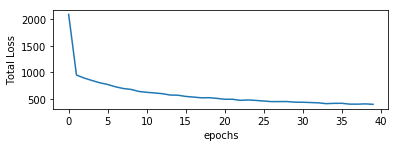

/opt/conda/envs/fastai/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


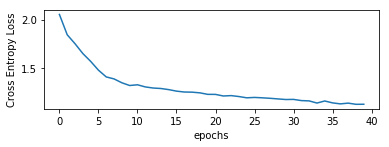

In [13]:
plt.subplot(2,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(2,1,2)
#plt.plot(history.history['localization_output_iou_metric'])
#plt.xlabel('epochs')
#plt.ylabel('IoU Metric')
#plt.show()
plt.subplot(2,1,2)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [15]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [25]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

ValueError: too many values to unpack (expected 4)

In [ ]:
# print(np.mean(np.array(test_cvscores)[:,1]))
# print(np.std(np.array(test_cvscores)[:,1]))

# print(np.mean(np.array(validation_cvscores)[:,1]))
# print(np.std(np.array(validation_cvscores)[:,1]))

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

56
0.6096353
0.6096353
0.6096353


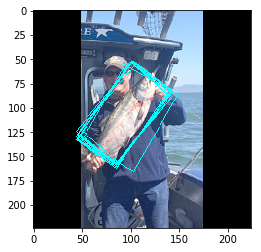

In [198]:
idx = 56
print(idx)
img = test_images[idx]
[[h,w,cx,cy,angle]] = mod.predict(np.expand_dims(test_images[idx],0))[0]
print(angle)
rectange_points = [(w/2.0,h/2.0),(w/2.0,-h/2.0),(-w/2.0,-h/2.0),((-w/2.0,h/2.0))]
points = []
#angle = (3.14159265358979323846/2) - angle
print(angle)
for xr,yr in rectange_points:
    xtemp = math.cos(angle)*xr - math.sin(angle)*yr
    yr = math.sin(angle)*xr + math.cos(angle)*yr
    xr = xtemp
    
    xr = xr + cx
    yr = yr + cy
    points.append(xr)
    points.append(yr)
print(angle)
pts = np.array(points)
pts = pts.reshape((-1,1,2))
img = cv2.polylines(img,np.int32([pts]),True,(0,255,255))
pil_im = Image.fromarray(img)
plt.imshow(pil_im)

In [116]:
mod.predict(np.expand_dims(test_images[idx],0))[0]

array([[ 88.61373   ,  96.06156   , 108.71138   , 115.66697   ,
          0.62759846]], dtype=float32)

In [39]:
idx = 3
mod.predict(np.expand_dims(test_images[idx],0))[0]

array([[ 45.940697  , 104.96522   ,  76.474686  , 158.10019   ,
         -0.35100347]], dtype=float32)

In [109]:
mod.predict(np.expand_dims(test_images[idx],0))[0]

array([[ 88.61373   ,  96.06156   , 108.71138   , 115.66697   ,
          0.62759846]], dtype=float32)

In [122]:
angle

0.49396342